In [147]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
from sss import make_random_shares
from ass import getAdditiveShares
from ass import reconstructSecret
#np.random.seed(0)

In [148]:
# 2 servers
M=2
# three datatable's size
k=3
N=10
d1=np.random.choice(np.arange(1, 2*N), replace=False, size=(N, 1))
d2=np.random.choice(np.arange(1, 2*N), replace=False, size=(N, 1))
d3=np.random.choice(np.arange(1, 2*N), replace=False, size=(N, 1))

In [181]:
# hashtable's size 
# generate the corresponding hash tables

def generate_hash_table(d, N=10):
    dic={}
    for i in range(1, 2*N+1):
        dic[i]=0
    arr_d=d.tolist()
    for a in arr_d:
        dic[a[0]]+=1
    return dic

dic1=generate_hash_table(d1)
dic2=generate_hash_table(d2)   
dic3=generate_hash_table(d3)

In [150]:
s_1=list(dic1.values())
s_2=list(dic2.values())
s_3=list(dic3.values())

In [151]:
s_1, s_2, s_3

([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0],
 [0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0])

In [178]:
# make the secret shares with 2 servers,  for 3 data owners correspondingly 
def generate_shares(S, M):
    share1=[]
    share2=[]
    for s in S:
        tmp=getAdditiveShares(s, M)
        share1.append(tmp[0])
        share2.append(tmp[1])
    return share1, share2

s_11, s_12= generate_shares(s_1, 2)
s_21, s_22= generate_shares(s_2, 2)
s_31, s_32= generate_shares(s_3, 2)

def reconstruct(s11, s12):
    return [reconstructSecret([s11[i], s12[i]]) for i in range(len(s11))]

In [168]:
np.array(s_11), np.array(s_12)
#s_21, s_22
#s_31, s_32

#=======test share=========
#reconstruct(s_11, s_12)

(array([19902,  4205,  1946, 35896, 34810, 21673, 97409, 34405, 21959,
        63608, 27349, 92193, 79493, 33600, 34543, 33429, 35679, 33183,
          389, 62800]),
 array([80098, 95795, 98055, 64105, 65191, 78328,  2592, 65596, 78042,
        36392, 72652,  7807, 20507, 66401, 65457, 66571, 64322, 66817,
        99611, 37200]))

In [154]:
# server's side computation 
# \sigma s_i1, i=1,2,3 

def aggregate_share(s11, s21, s31):
    return (np.array(s11)+np.array(s21)+np.array(s31)).tolist()

In [155]:
# server's side aggregate all the shares
agg_s1=aggregate_share(s_11, s_21, s_31)
agg_s2=aggregate_share(s_12, s_22, s_32)

In [156]:
'''
to improve the security of scheme during the server--> database, encrypt the data shares with the cyclic group omitted
'''

# server execute the shares to protect the shares, optional operation in cyclic group.
v_k=[k]*2*N
v_s1, v_s2= generate_shares(v_k, 2)

# for each server, to mask the aggregation value by the cyclic group
# subgroup=[1,3,4,5,9], mod 11, g=5
alpha=13
ita=11
g=5
def Groupmulti(m):
    ita_prime=ita*alpha
    return pow(g, m)%ita_prime # modoul
def G_vect(v_m):
    return [Groupmulti(m) for m in v_m]

# server1 and server 2 compute with v_s1    g^(agg_s1-v_s1)

tmp_s1=(np.array(agg_s1)-np.array(v_s1)).tolist()
tmp_s2=(np.array(agg_s2)-np.array(v_s2)).tolist()


final_s1=G_vect(tmp_s1)
final_s2=G_vect(tmp_s2)
# reconstruct the shares with cyclic group and mod g^{\sigma v_si} mod ita
np.array(final_s1)*np.array(final_s2)%11

In [163]:
#reconstruct(tmp_s1, tmp_s2)

In [161]:
# each server compute on its shares, and send back to the 
tmp_1=[reconstructSecret([agg_s1[i]]) for i in range(len(agg_s1))]
tmp_2=[reconstructSecret([agg_s2[i]]) for i in range(len(agg_s1))]

In [162]:
# finally every data owner will compute a result 
reconstruct(tmp_1, tmp_2)

[1, 2, 3, 1, 2, 3, 2, 1, 1, 2, 2, 1, 2, 3, 0, 1, 3, 0, 0, 0]

In [202]:
# use to evaluate the data size, first dump into pickle, and convert to byte size 
import math
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, 2)
    s = round(size_bytes / p, 2)
    # use mb
    return s
    
    #return "%s %s" % (s, size_name[i])

# network_data = pickle.dumps(data)
# len(network_data)

In [207]:
# time complexity and space complexity 
import time
import pickle 


# to output the size of secret shares and running time (does not consider the communication times)
# for the shares memory, we use the secure shares as the memory size 
def main(N=10):
    # original data generation of size N, from 2*N number 
    start=time.time()
    plain=0
    share=0
    d1=np.random.choice(np.arange(1, 2*N), replace=False, size=(N, 1))
    d2=np.random.choice(np.arange(1, 2*N), replace=False, size=(N, 1))
    d3=np.random.choice(np.arange(1, 2*N), replace=False, size=(N, 1))
    
    plain+=len(pickle.dumps(d1))
    plain+=len(pickle.dumps(d2))
    plain+=len(pickle.dumps(d3))
    
    dic1=generate_hash_table(d1, N)
    dic2=generate_hash_table(d2, N)   
    dic3=generate_hash_table(d3, N)
    
    s_1=list(dic1.values())
    s_2=list(dic2.values())
    s_3=list(dic3.values())
    
    # generate shares and send to the server
    s_11, s_12= generate_shares(s_1, 2)
    s_21, s_22= generate_shares(s_2, 2)
    s_31, s_32= generate_shares(s_3, 2)
    
    share+=len(pickle.dumps(s_11))
    share+=len(pickle.dumps(s_12))
    share+=len(pickle.dumps(s_21))
    share+=len(pickle.dumps(s_22))
    share+=len(pickle.dumps(s_31))
    share+=len(pickle.dumps(s_32))
    
    
    # the server construct the shares
    agg_s1=aggregate_share(s_11, s_21, s_31)
    agg_s2=aggregate_share(s_12, s_22, s_32)
    
    tmp_1=[reconstructSecret([agg_s1[i]]) for i in range(len(agg_s1))]
    tmp_2=[reconstructSecret([agg_s2[i]]) for i in range(len(agg_s1))]
    
    reconstruct(tmp_1, tmp_2)
    end=time.time()
    
    #return (end-start)
    return convert_size(plain), convert_size(share)

plain_res=[]
share_res=[]

for i in range(1, 7):
    plain, share=main(pow(10, i))
    plain_res.append(plain)
    share_res.append(share)
    

In [209]:
plain_res

[0.0, 0.0, 0.01, 0.11, 1.14, 11.44]

In [208]:
share_res

[0.0, 0.0, 0.04, 0.42, 4.22, 42.22]

In [ ]:
res=[]
for i in range(1, 7):
    res.append(main(pow(10, i)))

<ipython-input-212-64d038f45c0a>:7: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log',basex=10)


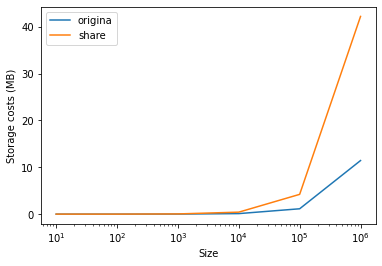

In [212]:
# plot the memory costs
import matplotlib.pyplot as plt  

x=[pow(10, i) for i in range(1, 7)]
plt.plot(x,plain_res, label='origina')
plt.plot(x,share_res, label='share')
plt.xscale('log',basex=10)
plt.xlabel('Size')
plt.legend()
plt.ylabel('Storage costs (MB)')
plt.show()

<ipython-input-191-887b8a43983e>:6: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log',basex=10)


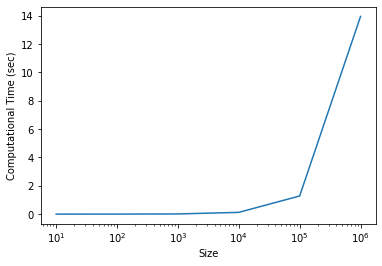

In [191]:
# plot function 
import matplotlib.pyplot as plt  

x=[pow(10, i) for i in range(1, 7)]
plt.plot(x,res)
plt.xscale('log',basex=10)
plt.xlabel('Size')
plt.ylabel('Computational Time (sec)')
plt.show()

In [45]:
# store the array into dataframe and read it
df1=pd.DataFrame(d1, columns=['A'])

df1.to_csv('df1.csv', index=False)
df1_new= pd.read_csv ('df1.csv')

In [48]:
df1_new

,A
0,9
1,2
2,5
3,15
4,7
5,18
6,12
7,16
8,13
9,10


In [49]:
# secret share building blocks function 

"""
The following Python implementation of Shamir's Secret Sharing is
released into the Public Domain under the terms of CC0 and OWFa:
https://creativecommons.org/publicdomain/zero/1.0/
http://www.openwebfoundation.org/legal/the-owf-1-0-agreements/owfa-1-0

See the bottom few lines for usage. Tested on Python 2 and 3.
"""

from __future__ import division
from __future__ import print_function

import random
import functools

# 12th Mersenne Prime
# (for this application we want a known prime number as close as
# possible to our security level; e.g.  desired security level of 128
# bits -- too large and all the ciphertext is large; too small and
# security is compromised)
_PRIME = 2 ** 127 - 1
_PRIME = 1613
#_PRIME = 13. 
# 13th Mersenne Prime is 2**521 - 1

_RINT = functools.partial(random.SystemRandom().randint, 0)

def _eval_at(poly, x, prime):
    """Evaluates polynomial (coefficient tuple) at x, used to generate a
    shamir pool in make_random_shares below.
    """
    accum = 0
    for coeff in reversed(poly):
        accum *= x
        accum += coeff
        accum %= prime
    return accum

def make_random_shares(secret, minimum, shares, prime=_PRIME):
    """
    Generates a random shamir pool for a given secret, returns share points.
    """
    if minimum > shares:
        raise ValueError("Pool secret would be irrecoverable.")

    poly = [secret] + [_RINT(prime - 1) for i in range(minimum - 1)]

    points = [(i, _eval_at(poly, i, prime))
              for i in range(1, shares + 1)]
    return points

def _extended_gcd(a, b):
    """
    Division in integers modulus p means finding the inverse of the
    denominator modulo p and then multiplying the numerator by this
    inverse (Note: inverse of A is B such that A*B % p == 1) this can
    be computed via extended Euclidean algorithm
    http://en.wikipedia.org/wiki/Modular_multiplicative_inverse#Computation
    """
    x = 0
    last_x = 1
    y = 1
    last_y = 0
    while b != 0:
        quot = a // b
        a, b = b, a % b
        x, last_x = last_x - quot * x, x
        y, last_y = last_y - quot * y, y
    return last_x, last_y

def _divmod(num, den, p):
    """Compute num / den modulo prime p

    To explain what this means, the return value will be such that
    the following is true: den * _divmod(num, den, p) % p == num
    """
    inv, _ = _extended_gcd(den, p)
    return num * inv

def _lagrange_interpolate(x, x_s, y_s, p):
    """
    Find the y-value for the given x, given n (x, y) points;
    k points will define a polynomial of up to kth order.
    """
    k = len(x_s)
    assert k == len(set(x_s)), "points must be distinct"
    def PI(vals):  # upper-case PI -- product of inputs
        accum = 1
        for v in vals:
            accum *= v
        return accum
    nums = []  # avoid inexact division
    dens = []
    for i in range(k):
        others = list(x_s)
        cur = others.pop(i)
        nums.append(PI(x - o for o in others))
        dens.append(PI(cur - o for o in others))
    den = PI(dens)
    num = sum([_divmod(nums[i] * den * y_s[i] % p, dens[i], p)
               for i in range(k)])
    return (_divmod(num, den, p) + p) % p

def recover_secret(shares, prime=_PRIME):
    """
    Recover the secret from share points
    (x, y points on the polynomial).
    """
    if len(shares) < 2:
        raise ValueError("need at least two shares")
    x_s, y_s = zip(*shares)
    return _lagrange_interpolate(0, x_s, y_s, prime)

In [50]:
def main():
    """Main function"""
    secret = 0
    shares = make_random_shares(secret, minimum=2, shares=2)

    print('Secret:                                                     ',
          secret)
    print('Shares:')
    if shares:
        for share in shares:
            print('  ', share)

    print('Secret recovered from minimum subset of shares:             ',
          recover_secret(shares[:3]))
    print('Secret recovered from a different minimum subset of shares: ',
          recover_secret(shares[-3:]))

if __name__ == '__main__':
    main()

Secret:                                                      0
Shares:
   (1, 1164)
   (2, 715)
Secret recovered from minimum subset of shares:              0
Secret recovered from a different minimum subset of shares:  0


In [54]:
make_random_shares(secret=4, minimum=2, shares=2)

[(1, 1535), (2, 1453)]